# Road Surface Sediment Storage
Amanda Manaster  
*2019.11.19*  

---
When a truck passes, two processes occur: **crushing and pumping**.  
    &emsp;*Crushing* creates more fine sediment in the existing sediment matrix by breaking down larger particles.  
    &emsp;*Pumping* makes fine sediment available for transport (i.e., adds the fine sediment to the transport available fines storage layer). 

We can think of the total storage as:  
$S=S_f+S_s+S_b$  
    &emsp;$S_f$= transport available fines (TAF) storage term [$m$]  
    &emsp;$S_s$= surfacing storage term; combination of fines ($S_{s_f}$), coarse particles ($S_{s_c}$) [$m$]  
    &emsp;$S_b$= ballast storage term; combination of fines, 20-30% ($S_{b_f}$), large rocks, 70-80% ($S_{b_r}$) [$m$]  

And the net mass balance as:  
$∆S=-\frac{V_{s,out}}{A}=-H_{s,out}$

$∆S$ = total change in storage [$m$]  
$V_{s,out}$ = volume of sediment leaving the road prism [$m^3$]  
$A$ = representative area of road [$m^2$]  
$H_{s,out}$ = depth of sediment leaving the road prism [$m$]    

---
## A Tri-Layered Conceptualization:
![](RoadTriLayer.png)  

---  
First, load in packages:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

from jupyterthemes import jtplot
jtplot.style(ticks=False, grid=True)

Instantiate empty lists for model run:

In [2]:
storm_depth = []
rainfall_rate = []
delta_t = []
storm_length = []
truck_pass = []
total_t = []

model_end = 175200 #hours == 6 years

Run a model loop to generate random rainfall based on averages from Peter Eagleson's _Ecohydrology_ and to generate stochastic truck passes:

In [3]:
np.random.seed(1) #Use seed to ensure consistent results with each run
time = 0 #model time; initial
T_b = 0  #average inter-storm duration; initial
T_r = 0  #average storm duration; initial
r = 0    #average intensity; initial

while time < model_end:
    truck = 0
    time_step = T_b+T_r
    
    if time_step/24 >= 1:
        day = int(time_step/24)
        frac_day = time_step/24 - int(time_step/24)
        
        for num in range(day):
            truck += np.random.randint(0,10)
            
        truck += round(np.random.randint(0,10)*frac_day)
    else:
        frac_day = time_step/24 - int(time_step/24)
        truck = round(np.random.randint(0,10)*frac_day)
    
    storm_length.append(T_r)             #length of storm
    storm_depth.append(r*T_r)            #depth of storm
    rainfall_rate.append(r)              #rate of rainfall
    delta_t.append(time_step)            #length of each time step; variable
    total_t.append(time)                 #model time
    truck_pass.append(truck)             #number of truck passes
    
    T_b = np.random.exponential(90.5)    #average inter-storm duration, hr
    T_r = np.random.exponential(2.705*2) #average storm duration, hr
    r = np.random.exponential(2)         #average intensity, mm/hr
    
    time += T_b+T_r

Because we have a hefty data set, we wrap these data in a Pandas dataframe for ease of plotting.

In [4]:
df = pd.DataFrame() #Create dataframe

df['time'] = total_t
df['delta_t'] = delta_t
df['day'] = np.divide(total_t,24).astype('int64')
df['storm_depth'] = storm_depth
df['rainfall_rate'] = rainfall_rate
df['storm_length'] = storm_length
df['truck_pass'] = truck_pass

day0 = datetime(2018, 10, 1)
df.set_index(pd.DatetimeIndex([day0+timedelta(hours=time) for time in df.time]), inplace=True) #Set index of dataframe

df.head()

,time,delta_t,day,storm_depth,rainfall_rate,storm_length,truck_pass
2018-10-01 00:00:00.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
2018-10-23 18:04:10.686243,546.069635,546.069635,22,4.000265,0.274217,14.587945,104
2018-10-29 21:30:25.616920,693.507116,147.437481,28,0.769405,1.460255,0.526897,30
2018-10-30 09:50:00.511037,705.833475,12.326359,29,18.734350,6.334918,2.957315,5
2018-10-31 07:36:04.991436,727.601387,21.767911,30,0.567193,0.306582,1.850051,4


We resample the data to get a daily time step.

In [5]:
df_day = df.resample('D').sum().fillna(0)
df_day.truck_pass = df_day.truck_pass.round()
df_day['day'] = np.arange(0, len(df_day), 1)
df_day.head()

,time,delta_t,day,storm_depth,rainfall_rate,storm_length,truck_pass
2018-10-01,0.0,0.0,0,0.0,0.0,0.0,0
2018-10-02,0.0,0.0,1,0.0,0.0,0.0,0
2018-10-03,0.0,0.0,2,0.0,0.0,0.0,0
2018-10-04,0.0,0.0,3,0.0,0.0,0.0,0
2018-10-05,0.0,0.0,4,0.0,0.0,0.0,0


And now we can plot the stochastically generated daily rainfall.

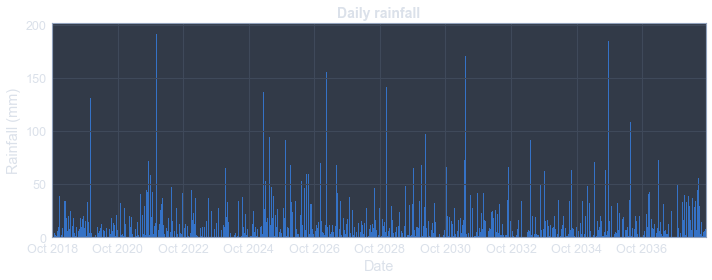

In [6]:
ticklabels = [item.strftime('%b %Y') for item in df_day.index[::366*2]]
fig, ax = plt.subplots(figsize=(10,4))
df_day.plot(y='storm_depth', ax=ax, legend=False, kind='bar', width=7)
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Daily rainfall', fontweight='bold', fontsize=14)
plt.xticks(np.arange(0,366*2*len(ticklabels),366*2), ticklabels, rotation=0)
plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\Rainfall.png', dpi=300)
plt.show()

Now that we have the time step of the model, our rainfall, and our truck passes, we can start to calculate sediment transport rates:

In [7]:
#Define constants
L = 4.57 #representative segment of road, m
rho_w = 1000 #kg/m^3
rho_s = 2650 #kg/m^3
g = 9.81 #m/s^2
S = 0.0825 #m/m; 8% long slope, 2% lat slope
tau_c = 0.110 #N/m^2; assuming d50 is approx. 0.0625 mm; value from https://pubs.usgs.gov/sir/2008/5093/table7.html
d50 = 6.25e-5 #m
d95 = 0.050 #m
n_s = 0.0474*(d50)**(1/6) #approx Manning's n for grains

And finally, we can look at the evolution of the road through time!

## Create loop that goes through model time:
1. Create fines storage, $S_{f_0}$; surfacing storage, $S_{s_0}$; and ballast storage, $S_{b_0}$:  
    &emsp;$S_{f_{0}} = 0$  
    
    &emsp;$S_{s_0}=S_{{sc}_0}+S_{{sf}_0}$     
    &emsp;&emsp;$S_{s_{f_0}}=h_{s_0}*f_{sf_0}$   
    &emsp;&emsp;$S_{s_{c_0}}=h_{s_0}*f_{sc_0}$  
    
    &emsp;$S_{b_0}=S_{{bf}_0}+S_{{bc}_0}$  
    &emsp;&emsp;$S_{{bf}_0}=h_{b_0}*f_{bf_0}$   
    &emsp;&emsp;$S_{{bc}_0}=h_{b_0}*f_{bc_0}$  


2. Loop through dataframe:
    * Calculate $S_{f_i}$                 
    * Calculate $S_{s_i}$  
    * Calculate $S_{b_i}$       
    
For simplicity, we'll assume the following:  
    &emsp;$h_{s_0}$ = 0.23 [m] (https://www.fhwa.dot.gov/construction/pubs/ots15002.pdf, A4 Table 3)   
    &emsp;$f_{sf_0}$ = 0.275 [-] (from Palix watershed analysis)  
    &emsp;$f_{sc_0}$ = 0.725 [-] (from Palix watershed analysis)  
    &emsp;$h_{b_0}$ = 0.60 [m]  
    &emsp;$f_{bf_0}$ = 0.20 [-]  
    &emsp;$f_{bc_0}$ = 0.80 [-]  

In [8]:
#define constants
h_s = 0.23
f_sf = 0.275
f_sc = 0.725

h_b = 0.60
f_bf = 0.20
f_br = 0.80

#The following four constants can be adjusted based on observations
kas = 1.37e-8 #crushing constant... value is easily changeable
kab = 1e-8
u_p = 9.37e-6 #m (4.27e-5m^3/4.57 m^2)  6 tires * 0.225 m width * 0.01 m length * 3.175e-3 m treads
u_f = 4.69e-6 #m
p = 0.20 #[-] (Applied Hydrogeology 3rd Ed. by C.W. Fetter, Table 3.4)

In [9]:
#Create a new dataframe for our storage calculations
df_storage = pd.DataFrame()

df_storage['time'] = total_t
df_storage['day'] = np.divide(total_t,24).astype('int64')
day0 = datetime(2018, 10, 1)
df_storage.set_index(pd.DatetimeIndex([day0+timedelta(hours=time) for time in df_storage.time]), inplace=True)

In [10]:
#Step 1!
#Initialize numpy arrays for calculations
dS_f = np.zeros(len(df))
S_f = np.zeros(len(df))
S_s = np.zeros(len(df))
S_sc = np.zeros(len(df))
S_sf = np.zeros(len(df))
S_b = np.zeros(len(df))
S_bc = np.zeros(len(df))
S_bf = np.zeros(len(df))
Hs_out = np.zeros(len(df))
q_s = np.zeros(len(df))
h_f = np.zeros(len(df))
k_s = np.zeros(len(df))
H = np.zeros(len(df))
tau = np.zeros(len(df))
shear_stress = np.zeros(len(df))
n = np.zeros(len(df))
f_s = np.zeros(len(df))

n_tp = df.truck_pass.to_numpy()
t = df.delta_t.to_numpy()
t_storm = df.storm_length.to_numpy()
rainfall = df.rainfall_rate.to_numpy()

q_f1 = np.zeros(len(df))
q_f2 = np.zeros(len(df))
q_as = np.zeros(len(df))
q_ab = np.zeros(len(df))
sed_avail = np.zeros(len(df))
sed_cap = np.zeros(len(df))
value = np.zeros(len(df))

#Initial conditions for fines, surfacing, ballast
S_f[0] = 0
S_s[0] = h_s*(f_sf + f_sc)
S_sc[0] = h_s*(f_sc)
S_sf[0] = h_s*(f_sf)
S_b[0] = h_b*(f_bf + f_br)
S_bc[0] = h_b*(f_br)
S_bf[0] = h_b*(f_bf)

In [32]:
#Step 2!
for i in range(1, len(df)):
    q_f1[i] = u_p*(S_sf[i-1]/S_s[i-1])*n_tp[i]/(t[i]*3600)
    q_f2[i] = u_f*(S_bf[i-1]/S_b[i-1])*n_tp[i]/(t[i]*3600)
    q_as[i] = kas*(S_sc[i-1]/S_s[i-1])*n_tp[i]/(t[i]*3600)
    q_ab[i] = kab*(S_bc[i-1]/S_b[i-1])*n_tp[i]/(t[i]*3600)
    
    S_bc[i] = S_bc[i-1] - q_ab[i]*(t[i]*3600)
    S_sc[i] = S_sc[i-1] - q_as[i]*(t[i]*3600)
    
    S_bf[i] = S_bf[i-1] + q_ab[i]*(t[i]*3600) - q_f2[i]*(t[i]*3600)
    S_sf[i] = S_sf[i-1] + q_as[i]*(t[i]*3600) - q_f1[i]*(t[i]*3600) + q_f2[i]*(t[i]*3600)
        
    S_s[i] = S_sc[i] + S_sf[i]
    S_b[i] = S_bc[i] + S_bf[i]
    
    h_f[i] = (1/p)*(q_f1[i]*(t[i]*3600) + S_f[i-1])
    
    if d95 > h_f[i]:
        k_s[i] = d95 - h_f[i]
    elif d95 <= h_f[i]:
        k_s[i] = d50
    
    n[i] = 0.0474*(k_s[i])**(1/6)
    f_s[i] = (n_s/n[i])**(1.5)
    
    #Calculate water depth assuming uniform overland flow
    H[i] = ((n[i]*(rainfall[i]/3.6e6)*L)/(S**(1/2)))**(3/5)
    
    tau[i] = rho_w*g*H[i]*S
    
    #Calculate shear stress
    shear_stress[i] = tau[i]*f_s[i]
    
    #Calculate sediment transport rate
    if (shear_stress[i]-tau_c) >= 0:
        q_s[i] = ((10**(-4.348))/(rho_s*((d50)**(0.811))))*(shear_stress[i]-tau_c)**(2.457)/L
    else:
        q_s[i] = 0

    #Create a condition column based on sediment transport capacity vs sediment supply
    sed_avail[i] = q_f1[i]*(t[i]*3600.)
    sed_cap[i] = q_s[i]*(t_storm[i]*3600.)
    value[i] = (sed_avail[i]-sed_cap[i])
        
    if value[i] < 0:
        Hs_out[i] = np.minimum(sed_avail[i]+S_f[i-1], sed_cap[i])
        dS_f[i] = sed_avail[i] - Hs_out[i]

    else:
        Hs_out[i] = sed_cap[i]
        dS_f[i] = sed_avail[i] - Hs_out[i]

    S_f[i] = S_f[i-1] + dS_f[i] if (S_f[i-1] + dS_f[i]) > 0 else 0
    
#Add all numpy arrays to the Pandas dataframe
df['q_s'] = q_s
df_storage['n'] = n
df_storage['water_depth'] = H
df_storage['shear_stress'] = shear_stress
df_storage['hf'] = h_f
df_storage['nt'] = n
df_storage['f_s'] = f_s
df_storage['q_s'] = q_s
df_storage['qf1'] = q_f1
df_storage['qf2'] = q_f2
df_storage['dS_f'] = dS_f
df_storage['S_f'] = S_f
df_storage['S_s'] = S_s
df_storage['S_sc'] = S_sc
df_storage['S_sf'] = S_sf
df_storage['S_b'] = S_b
df_storage['Hs_out'] = Hs_out
df_storage['sed_avail'] = sed_avail
df_storage['sed_cap'] = sed_cap

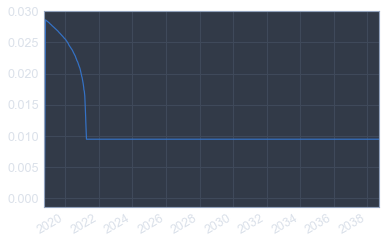

In [33]:
_= df_storage.nt.plot()

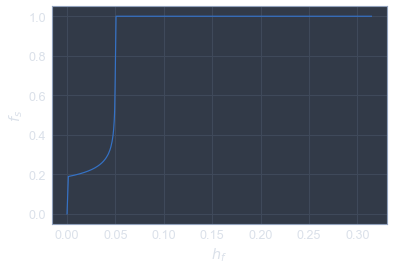

In [12]:
_ = plt.plot(h_f, f_s)
_ = plt.xlabel(r'$h_f$')
_ = plt.ylabel(r'$f_s$')

In [13]:
#Look at our dataframe
df_storage

,time,day,n,water_depth,shear_stress,hf,q_s,qf1,qf2,dS_f,S_f,S_s,S_sc,S_sf,S_b,Hs_out,sed_avail,sed_cap
2018-10-01 00:00:00.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.230000,0.166750,0.063250,0.600000,0.0,0.000000,0.0
2018-10-23 18:04:10.686243,546.069635,22,0.028640,0.000033,0.005124,0.001340,0.0,1.363186e-10,4.962330e-11,0.000268,0.000268,0.229830,0.166749,0.063081,0.599902,0.0,0.000268,0.0
2018-10-29 21:30:25.616920,693.507116,28,0.028602,0.000091,0.013992,0.001726,0.0,1.453585e-10,5.298270e-11,0.000077,0.000345,0.229781,0.166749,0.063032,0.599874,0.0,0.000077,0.0
2018-10-30 09:50:00.511037,705.833475,29,0.028596,0.000220,0.033757,0.001790,0.0,2.896138e-10,1.056028e-10,0.000013,0.000358,0.229772,0.166749,0.063024,0.599870,0.0,0.000013,0.0
2018-10-31 07:36:04.991436,727.601387,30,0.028591,0.000036,0.005487,0.001841,0.0,1.311858e-10,4.783766e-11,0.000010,0.000368,0.229766,0.166749,0.063017,0.599866,0.0,0.000010,0.0
2018-11-02 07:55:49.877940,775.930522,32,0.028586,0.000109,0.016686,0.001893,0.0,5.908294e-11,2.154601e-11,0.000010,0.000379,0.229759,0.166749,0.063011,0.599862,0.0,0.000010,0.0
2018-11-03 22:08:25.924169,814.140534,33,0.028570,0.000029,0.004473,0.002047,0.0,2.241728e-10,8.175404e-11,0.000031,0.000409,0.229740,0.166748,0.062991,0.599851,0.0,0.000031,0.0
2018-11-13 00:32:19.322215,1032.538701,43,0.028513,0.000057,0.008861,0.002625,0.0,1.470433e-10,5.363354e-11,0.000116,0.000525,0.229666,0.166748,0.062918,0.599809,0.0,0.000116,0.0
2018-11-16 06:38:50.013444,1110.647226,46,0.028491,0.000102,0.015812,0.002843,0.0,1.551913e-10,5.663728e-11,0.000044,0.000569,0.229639,0.166748,0.062891,0.599793,0.0,0.000044,0.0
2018-11-27 17:19:27.998878,1385.324444,57,0.028411,0.000094,0.014622,0.003626,0.0,1.583020e-10,5.778477e-11,0.000157,0.000725,0.229539,0.166747,0.062792,0.599736,0.0,0.000157,0.0


Now, let's plot our data:

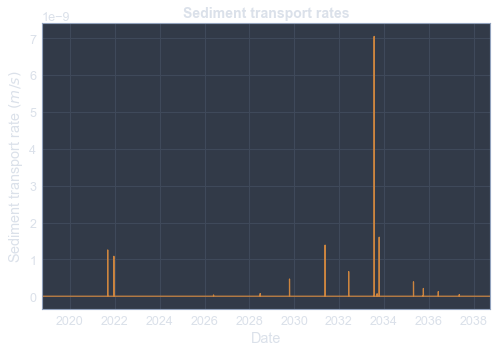

In [14]:
#Resample to daily data again
df_day_sed = df.resample('D').sum().fillna(0)
df_day_sed['day'] = np.arange(0, len(df_day_sed), 1)

#Plot sediment transport rates over time
fig2, ax2 = plt.subplots(figsize=(7,5))
df_day_sed.plot(y='q_s', ax=ax2, color = 'peru', legend=False)
plt.xlabel('Date')
plt.ylabel(r'Sediment transport rate $(m/s)$')
plt.title('Sediment transport rates', fontweight='bold', fontsize=14)
plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\Sediment.png', dpi=300)
plt.show()

In [15]:
df4 = df_storage.resample('D').mean().fillna(method='ffill')
df4['day'] = np.arange(0, len(df4), 1)
df4['S_f_mm'] = df4.S_f*1000

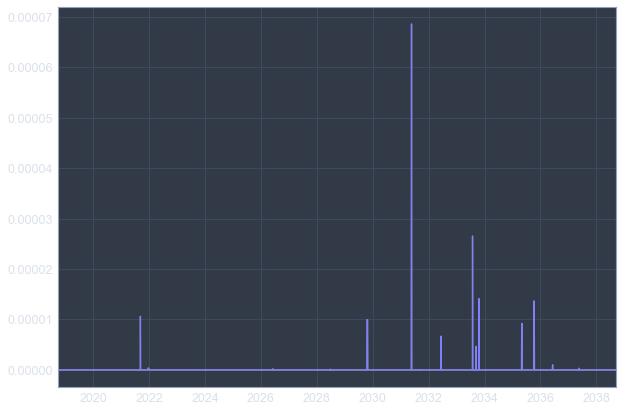

In [16]:
fig13, ax13 = plt.subplots(figsize=(10,7))
_ = df4.sed_cap.plot(color = 'white')
_ = df4.Hs_out.plot(color='blue', alpha=0.5)

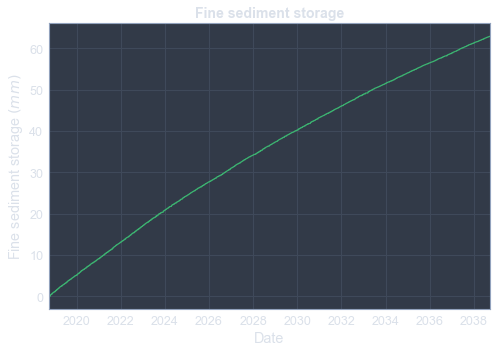

In [17]:
fig3, ax3 = plt.subplots(figsize=(7,5))
df4.plot(y='S_f_mm', ax=ax3, color = 'mediumseagreen', legend=False)
plt.xlabel('Date')
plt.ylabel(r'Fine sediment storage $(mm)$')
plt.title('Fine sediment storage', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

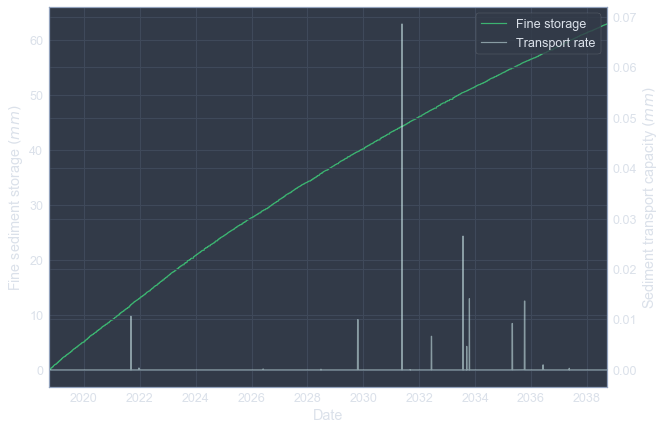

In [18]:
df_day_sed['q_s_mm'] = df_day_sed.q_s/1e-3
df4['sed_cap_mm'] = df4.sed_cap/1e-3


fig8, ax8 = plt.subplots(figsize=(10,7))
df4.plot(y='S_f_mm', ax=ax8, color = 'mediumseagreen', legend=False, label='Fine storage')
ax8.set_xlabel('Date')
ax8.set_ylabel(r'Fine sediment storage $(mm)$')
#ax8.set_ylim(0, 8)

ax9 = ax8.twinx()
df4.plot(y='sed_cap_mm', ax=ax9, color = 'lightcyan', legend=False, label='Transport rate', alpha=0.5)
ax9.set_ylabel(r'Sediment transport capacity $(mm)$')
fig8.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax8.transAxes)
#ax9.set_ylim(0, 8)

plt.show()

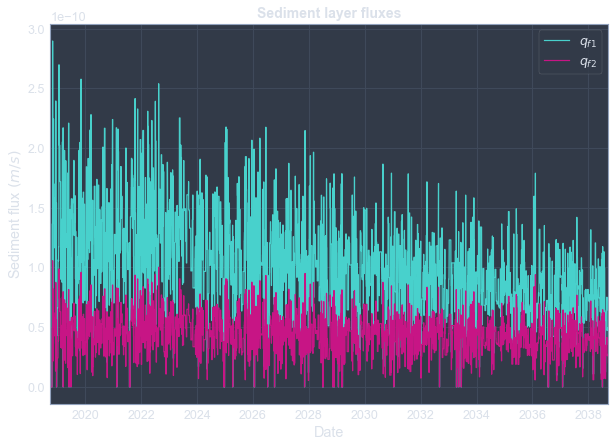

In [19]:
fig10, ax10 = plt.subplots(figsize=(10,7))
df4.plot(y='qf1', ax=ax10, color = 'mediumturquoise', legend=False, label=r'$q_{f1}$')
df4.plot(y='qf2', ax=ax10, color = 'mediumvioletred', legend=False, label=r'$q_{f2}$')

ax10.set_ylabel(r'Sediment flux $(m/s)$')
ax10.set_xlabel('Date')
fig10.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax10.transAxes)

plt.title('Sediment layer fluxes', fontweight='bold', fontsize=14)
plt.show()

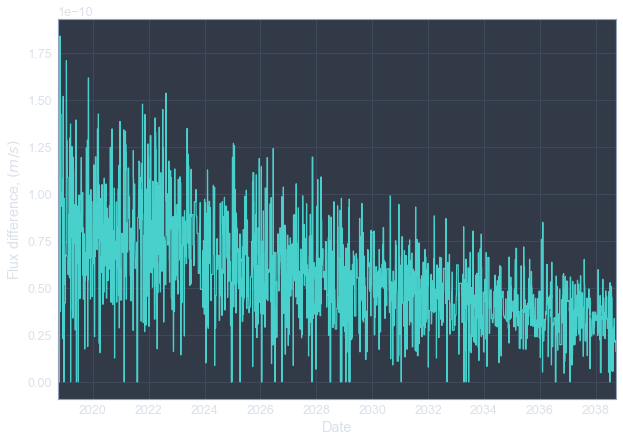

In [20]:
df4['diff'] = df4.qf1-df4.qf2
fig11, ax11 = plt.subplots(figsize=(10,7))
df4.plot(y='diff', ax=ax11, color = 'mediumturquoise', legend=False)
ax11.set_ylabel(r'Flux difference, $(m/s)$')
ax11.set_xlabel('Date')
plt.show()

In [21]:
df5 = df_storage.resample('D').mean().fillna(method='ffill')
#df5['hour'] = np.arange(0, len(df5), 1)

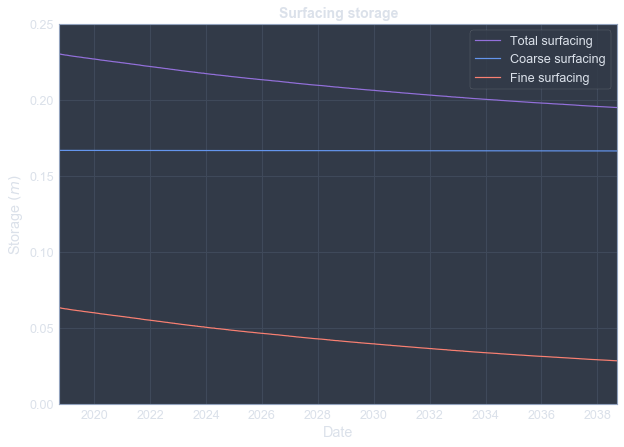

In [22]:
fig5, ax5 = plt.subplots(figsize=(10,7))

df5.plot(y='S_s', ax=ax5, color = 'mediumpurple', legend=False, label='Total surfacing')
df5.plot(y='S_sc', ax=ax5, color = 'cornflowerblue', legend=False, label='Coarse surfacing')
df5.plot(y='S_sf', ax=ax5, color = 'salmon', legend=False, label='Fine surfacing')

ax5.set(ylabel=r'Storage $(m)$')
ax5.set_ylim(0, 0.25)
ax5.set_title('Surfacing storage', fontweight='bold', fontsize=14)
fig5.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax5.transAxes)
plt.xlabel('Date')
plt.show()

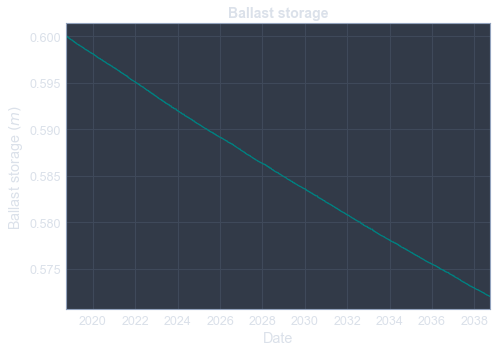

In [23]:
fig7, ax7 = plt.subplots(figsize=(7,5))
df5.plot(y='S_b', ax=ax7, color = 'teal', legend=False)
#ax7.set_ylim(0, 0.6)
plt.xlabel('Date')
plt.ylabel(r'Ballast storage $(m)$')
plt.title('Ballast storage', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [24]:
df_data = df_storage.resample('M').sum().fillna(0)
df_data

,time,day,n,water_depth,shear_stress,hf,q_s,qf1,qf2,dS_f,S_f,S_s,S_sc,S_sf,S_b,Hs_out,sed_avail,sed_cap
2018-10-31,2.673012e+03,109,0.114429,0.000380,0.058360,0.006697,0.000000e+00,7.024766e-10,2.560464e-10,0.000368,0.001339,1.149148,0.833745,0.315403,2.999512,0.000000e+00,0.000368,0.000000e+00
2018-11-30,5.118581e+03,211,0.142570,0.000392,0.060454,0.013034,0.000000e+00,7.437922e-10,2.713557e-10,0.000357,0.002607,1.148343,0.833740,0.314603,2.999050,0.000000e+00,0.000357,0.000000e+00
2018-12-31,2.643868e+04,1093,0.424756,0.001378,0.214778,0.068078,0.000000e+00,1.556557e-09,5.689580e-10,0.000335,0.013616,3.441350,2.501197,0.940153,8.995034,0.000000e+00,0.000335,0.000000e+00
2019-01-31,1.836641e+04,763,0.196808,0.000377,0.059403,0.045132,0.000000e+00,1.258683e-09,4.610337e-10,0.000314,0.009026,1.604269,1.167215,0.437054,4.196705,0.000000e+00,0.000314,0.000000e+00
2019-02-28,2.329660e+04,967,0.195303,0.000750,0.119461,0.058851,0.000000e+00,8.592742e-10,3.152620e-10,0.000405,0.011770,1.602531,1.167204,0.435327,4.195699,0.000000e+00,0.000405,0.000000e+00
2019-03-31,3.174962e+04,1320,0.221697,0.001158,0.186497,0.080490,0.000000e+00,1.121687e-09,4.122395e-10,0.000417,0.016098,1.829789,1.333937,0.495852,4.794113,0.000000e+00,0.000417,0.000000e+00
2019-04-30,5.634838e+04,2341,0.330080,0.001196,0.194964,0.141694,0.000000e+00,1.426956e-09,5.254016e-10,0.000329,0.028339,2.742034,2.000890,0.741145,7.189627,0.000000e+00,0.000329,0.000000e+00
2019-05-31,4.462921e+04,1856,0.218154,0.000786,0.129700,0.109948,0.000000e+00,9.322696e-10,3.438805e-10,0.000318,0.021990,1.826067,1.333914,0.492153,4.791943,0.000000e+00,0.000318,0.000000e+00
2019-06-30,5.037550e+04,2094,0.216613,0.000847,0.141365,0.122021,0.000000e+00,8.801397e-10,3.251500e-10,0.000318,0.024404,1.824544,1.333905,0.490640,4.791052,0.000000e+00,0.000318,0.000000e+00
2019-07-31,2.785892e+04,1159,0.107499,0.000478,0.080608,0.067116,0.000000e+00,5.228042e-10,1.934097e-10,0.000297,0.013423,0.911502,0.666947,0.244555,2.395074,0.000000e+00,0.000297,0.000000e+00


In [25]:
#Subset data by water year
yr_1 = df_storage.Hs_out['2018-10-01':'2019-09-30'].sum()
yr_2 = df_storage.Hs_out['2019-10-01':'2020-09-30'].sum()
yr_3 = df_storage.Hs_out['2020-10-01':'2021-09-30'].sum()
yr_4 = df_storage.Hs_out['2021-10-01':'2022-09-30'].sum()
yr_5 = df_storage.Hs_out['2022-10-01':'2023-09-30'].sum()
yr_6 = df_storage.Hs_out['2023-10-01':'2024-09-30'].sum()
yr_7 = df_storage.Hs_out['2024-10-01':'2025-09-30'].sum()
yr_8 = df_storage.Hs_out['2025-10-01':'2026-09-30'].sum()
yr_9 = df_storage.Hs_out['2026-10-01':'2027-09-30'].sum()
yr_10 = df_storage.Hs_out['2027-10-01':'2028-09-30'].sum()
yr_11 = df_storage.Hs_out['2028-10-01':'2029-09-30'].sum()
yr_12 = df_storage.Hs_out['2029-10-01':'2030-09-30'].sum()
yr_13 = df_storage.Hs_out['2030-10-01':'2031-09-30'].sum()
yr_14 = df_storage.Hs_out['2031-10-01':'2032-09-30'].sum()
yr_15 = df_storage.Hs_out['2032-10-01':'2033-09-30'].sum()
yr_16 = df_storage.Hs_out['2033-10-01':'2034-09-30'].sum()
yr_17 = df_storage.Hs_out['2034-10-01':'2035-09-30'].sum()
yr_18 = df_storage.Hs_out['2035-10-01':'2036-09-30'].sum()
yr_19 = df_storage.Hs_out['2036-10-01':'2037-09-30'].sum()
yr_20 = df_storage.Hs_out['2037-10-01':'2038-09-30'].sum()


#Multiply Hs_out
sed_area = np.multiply([yr_1, yr_2, yr_3, yr_4, yr_5, yr_6, yr_7, \
                        yr_8, yr_9, yr_10, yr_11, yr_12, yr_13, yr_14, \
                        yr_15, yr_16, yr_17, yr_18, yr_19, yr_20], L)
sed_load = np.multiply(sed_area, rho_s)
years = [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, \
         2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038]

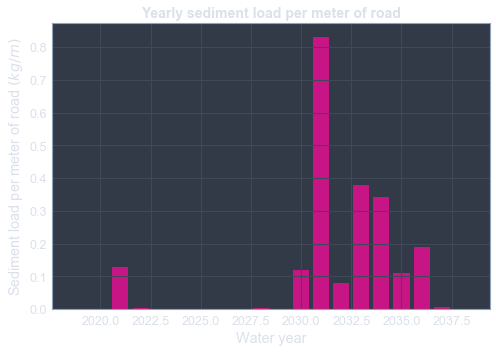

In [26]:
fig8, ax8 = plt.subplots(figsize=(7,5))
plt.bar(years, sed_load, color = 'mediumvioletred')
plt.xlabel('Water year')
plt.ylabel(r'Sediment load per meter of road $(kg/m)$')
plt.title('Yearly sediment load per meter of road', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

And do a sanity check. (i.e., is mass conserved?)

In [27]:
sed_sum_m2 = df_storage.Hs_out.sum()
sed_sum_kg_m = sed_sum_m2*rho_s*L
round(sed_sum_kg_m)

2.0

In [28]:
s = (df_storage.S_s[0]-df_storage.S_s[len(df_storage)-1])
b = (df_storage.S_b[0]-df_storage.S_b[len(df_storage)-1])
f = (df_storage.S_f[0]-df_storage.S_f[len(df_storage)-1])

round((s+b+f)*rho_s*L)

2.0